In [1]:
import json
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append("../../")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, average_precision_score
from tqdm import tqdm

from utils.ltt_utils import create_x_y
%load_ext autoreload
%autoreload 2

In [2]:
ANNOT_PATH = "../data/01_ovary_cuts/ovaries_annotations.json"
PRED_PATH = "../data/04_model_predictions/efficientdet/results.json"

In [3]:
with open(ANNOT_PATH, "r") as f:
    annotations = json.load(f)

with open(PRED_PATH, "r") as f:
    predictions = json.load(f)

In [4]:
predictions["4C_e"].keys()

dict_keys(['roi2', 'roi0', 'roi1', 'roi3', 'roi5', 'roi6', 'roi4'])

In [6]:
slide_id = np.random.randint(0, len(annotations))
slide_name = "4C_e" # list(annotations.keys())[slide_id]
roi_id = np.random.randint(0, len(annotations[slide_name]))
roi_name = "roi2" # list(annotations[slide_name].keys())[roi_id]

print(slide_name, roi_name)

4C_e roi2


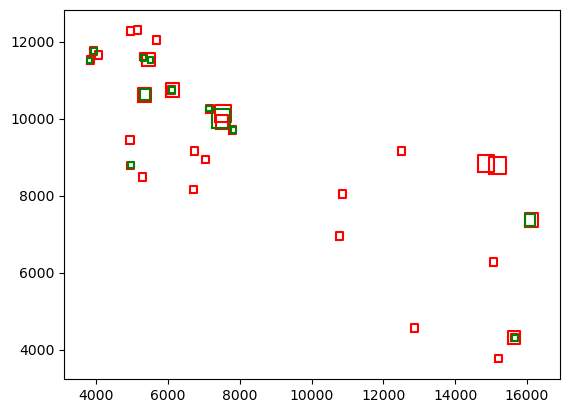

In [7]:
for i, pred_box in enumerate(predictions[slide_name][roi_name]["bboxes"]):
    if predictions[slide_name][roi_name]["scores"][i] > 0.0:
        x1, y1, x2, y2 = np.array(pred_box)
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")

for gt_box in annotations[slide_name][roi_name]["bboxes"]:
    x1, y1, x2, y2 = np.array(gt_box)
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="green")
# plt.imshow(img)
    

# mAP

In [8]:
IOU_TH = .3
X_pmf, y_pmf = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="PMF", with_depth=False
)
X_primary, y_primary = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="Primary", with_depth=False
)
X_secondary, y_secondary = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="Secondary", with_depth=False
)


In [9]:
ap_pmf = average_precision_score(y_pmf, X_pmf > 0)
ap_primary = average_precision_score(y_primary, X_primary > 0)
ap_secondary = average_precision_score(y_secondary, X_secondary > 0)

mAP = np.mean([ap_pmf, ap_primary, ap_secondary])
mAP


0.3281404694265608

# Precision-Recall curve for different depth

In [10]:
X, y = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="all", with_depth=True
)

In [11]:
precisions = []
recalls = []
step = 0.05
depth_ths = np.arange(.35, 1 + step, step)
for th_depth in tqdm(depth_ths):
    precisions_depth = []
    recalls_depth = []
    for th_obj in np.arange(0, 1, 0.01):
        X_depth = X[:, :, 0] * (X[:, :, 1] <= th_depth)
        precision = [precision_score(y[i], X_depth[i] >= th_obj, zero_division=1) for i in range(len(X))]
        recall = [recall_score(y[i], X_depth[i] >= th_obj, zero_division=1) for i in range(len(X))]
        precisions_depth.append(np.mean(precision))
        recalls_depth.append(np.mean(recall))
    precisions.append(precisions_depth)
    recalls.append(recalls_depth)


100%|██████████| 14/14 [02:07<00:00,  9.09s/it]


# Plot

In [12]:
len(precisions), len(precisions[0])

(14, 100)

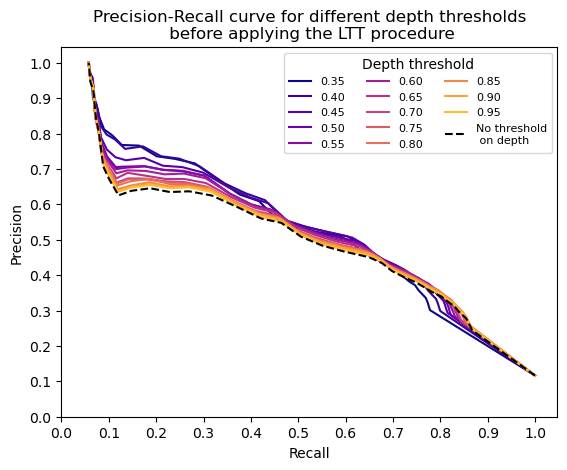

In [13]:
for i in range(len(precisions) - 1):
    d = depth_ths[i]
    plt.plot(recalls[i], precisions[i], label=f"{d:.2f}", color=plt.cm.plasma(i / len(precisions)))
plt.plot(recalls[-1], precisions[-1], label=f"No threshold\n on depth", color="black", linestyle="--")
# put legend outside of the plot
plt.legend(loc='upper right', title="Depth threshold", ncol=3, fontsize=8)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xticks(np.arange(0, 1.1, .1))
plt.yticks(np.arange(0, 1.1, .1))
plt.title("Precision-Recall curve for different depth thresholds\n before applying the LTT procedure")
plt.savefig("precision_recall_depth.pdf", bbox_inches="tight")
plt.show()

# Classwise

In [23]:
X_pmf, y_pmf = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="PMF", with_depth=False
)
X_primary, y_primary = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="Primary", with_depth=False
)
X_secondary, y_secondary = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="Secondary", with_depth=False
)

In [24]:
precisions_pmf = [precision_score(y_pmf[i], X_pmf[i] > .5, zero_division=1) for i in range(len(X_pmf))]
precisions_primary = [precision_score(y_primary[i], X_primary[i] > .5, zero_division=1) for i in range(len(X_primary))]
precisions_secondary = [precision_score(y_secondary[i], X_secondary[i] > .5, zero_division=1) for i in range(len(X_secondary))]

recalls_pmf = [recall_score(y_pmf[i], X_pmf[i] > .5, zero_division=1) for i in range(len(X_pmf))]
recalls_primary = [recall_score(y_primary[i], X_primary[i] > .5, zero_division=1) for i in range(len(X_primary))]
recalls_secondary = [recall_score(y_secondary[i], X_secondary[i] > .5, zero_division=1) for i in range(len(X_secondary))]


In [25]:
print("PMF PR", np.mean(precisions_pmf), np.mean(recalls_pmf))
print("Primary PR", np.mean(precisions_primary), np.mean(recalls_primary))
print("Secondary PR", np.mean(precisions_secondary), np.mean(recalls_secondary))

PMF PR 0.2490724234477236 0.88137446467875
Primary PR 0.5826444748822637 0.8699642284174658
Secondary PR 0.2340281926189671 0.9640287769784173
